In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
# %matplotlib notebook

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

import superscreen as sc

from huber_squid import huber_squid, huber_geometry

In [2]:
import ray
ray.init()

2021-07-10 18:45:38,251	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.80',
 'raylet_ip_address': '192.168.0.80',
 'redis_address': '192.168.0.80:6379',
 'object_store_address': 'tcp://127.0.0.1:60059',
 'raylet_socket_name': 'tcp://127.0.0.1:64850',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\LBISHO~1\\AppData\\Local\\Temp\\ray\\session_2021-07-10_18-45-22_230100_17892',
 'metrics_export_port': 65074,
 'node_id': 'e8c6caf72adf250a55c6a29517f697dce9b6fa9bb75bd6967a63e3fc'}

In [3]:
import time

## Device geometry

In [4]:
img = plt.imread("huber-image.png")
scale = np.where(img[385][:,0] == 1)[0].size / 5 # pixels per micron

origin = x0, y0 = (465, 610)

In [5]:
polygons = {
    name: scale * sc.geometry.rotate(points, 0)
    for name, points in huber_geometry(interp_points=101).items()
}

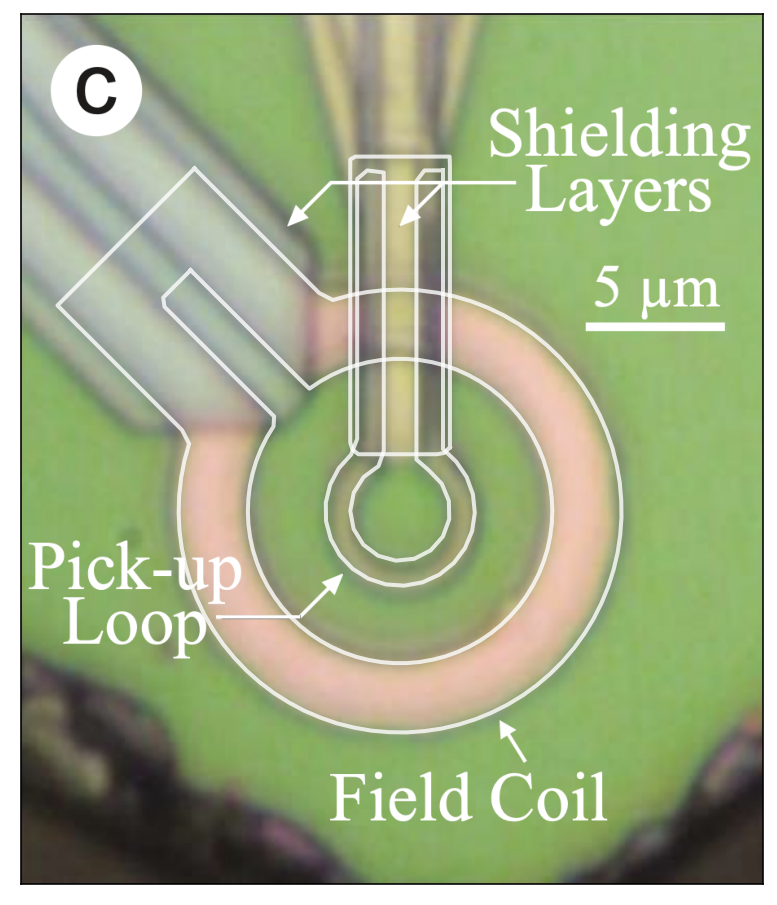

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
im = ax.imshow(img[:-200])
ax.set_yticks([])
ax.set_xticks([])

for name, points in polygons.items():
    if name in ["pl_hull", "fc_shield"]:
        continue
    xs, ys = points.T
    xs = -xs
    xs = xs + x0
    ys = ys + y0
    ax.plot(xs, ys, color='w', alpha=0.8, lw=2)
    
_ = ax.set_xlim(0, img.shape[1]-1)

## Simulate mutual inductance in the absence of a sample

In [7]:
squid = huber_squid()

layers = squid.layers
films = squid.films

# layers["sample_layer"] = sc.Layer("sample_layer", Lambda=1, z0=0.0)

# sample_points = np.array(
#     [
#         [-15.0, -15.0],
#         [-15.0,  15.0],
#         [ 15.0,  15.0],
#         [ 15.0, -15.0],
#     ]
# )

# films["sample"] = sc.Polygon(
#     "sample",
#     layer="sample_layer",
#     points=sample_points,
# )

_ = films.pop("fc_shield")

squid.layers = layers
squid.films = films

In [8]:
squid.make_mesh(min_triangles=10000, optimesh_steps=200)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 10605 triangles.
INFO:superscreen.device:Finished generating mesh with 5416 points and 10605 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


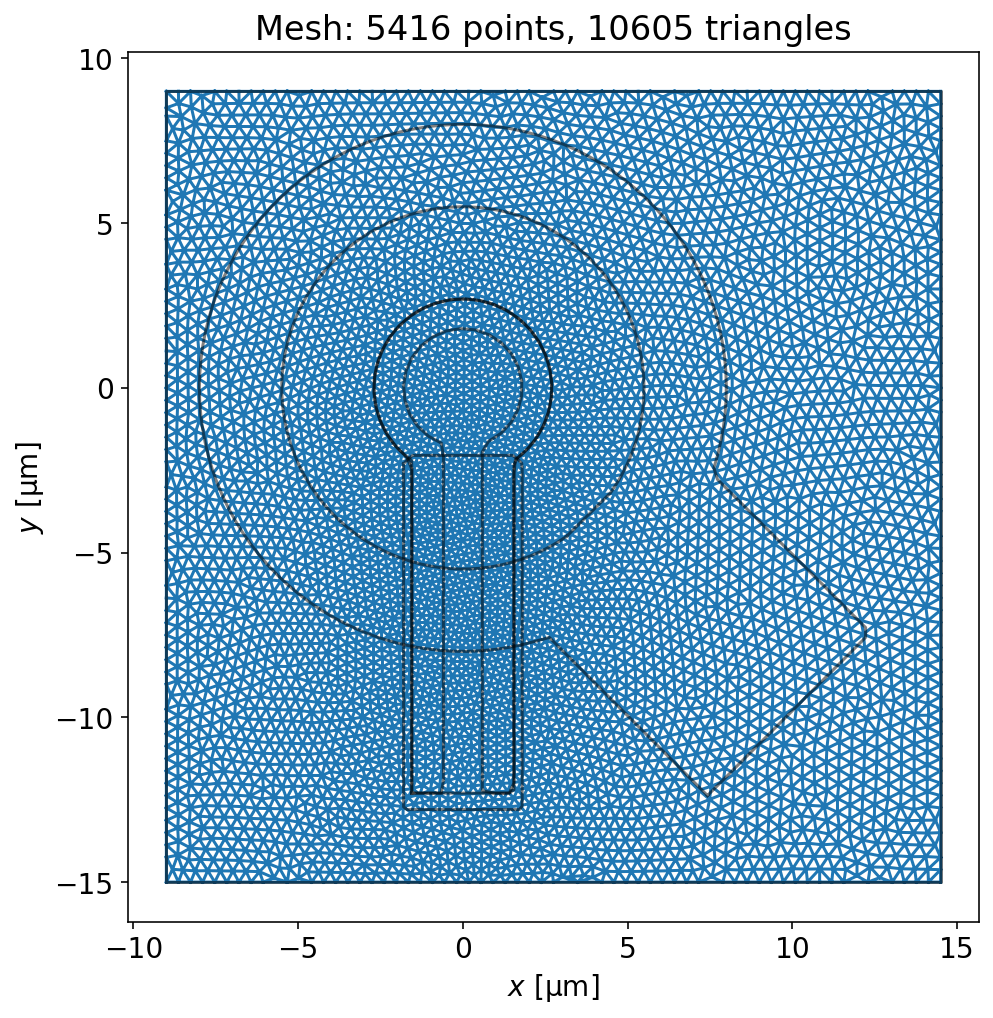

In [9]:
ax = squid.plot_mesh()
ax = squid.plot_polygons(ax=ax, color='k', alpha=0.5, legend=False)
_ = ax.set_title(
    f"Mesh: {squid.points.shape[0]} points, "
    f"{squid.triangles.shape[0]} triangles"
)
ax.figure.set_size_inches(8,8)

In [ ]:
t0 = time.time()

applied_field = sc.sources.ConstantField(0.0)

circulating_currents = {
    "fc_center": "1 mA"
}

solutions = sc.solve(
    device=squid,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="Phi_0/um**2",
    current_units="uA",
    iterations=6,
    coupled=True,
)
field_coil_solution = solutions[-1]

print(f"Elapsed time: {time.time() - t0:.3f} seconds")

In [11]:
t0 = time.time()

applied_field = sc.sources.ConstantField(0.0)

circulating_currents = {
    "fc_center": "1 mA"
}

solutions = sc.parallel.solve(
    device=squid,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="Phi_0/um**2",
    current_units="uA",
    iterations=6,
    coupled=True,
)
field_coil_solution = solutions[-1]

print(f"Elapsed time: {time.time() - t0:.3f} seconds")

(pid=10656) INFO:superscreen.parallel:Calculating BE response to applied field.
(pid=4164) INFO:superscreen.parallel:Calculating W1 response to applied field.
(pid=18720) INFO:superscreen.parallel:Calculating W2 response to applied field.
(pid=4164) WARNING:superscreen.brandt:Layer 'W1': The film thickness, d = 0.2300 µm, is greater than or equal to the London penetration depth, resulting in an effective penetration depth Λ = 0.0278 µm <= λ = 0.0800 µm. The assumption that the current density is nearly constant over the thickness of the film may not be valid. 
(pid=18720) WARNING:superscreen.brandt:Layer 'W2': The film thickness, d = 0.2500 µm, is greater than or equal to the London penetration depth, resulting in an effective penetration depth Λ = 0.0256 µm <= λ = 0.0800 µm. The assumption that the current density is nearly constant over the thickness of the film may not be valid. 
INFO:superscreen.parallel:-------------------------------Iteration [1 / 6]------------------------------

Elapsed time: 59.479 seconds


In [ ]:
ray_field_coil_solution = field_coil_solution

In [ ]:
field_coil_solution.equals(ray_field_coil_solution)

In [ ]:
flux = field_coil_solution.polygon_flux()
flux_ray = ray_field_coil_solution.polygon_flux()

In [ ]:
flux

In [ ]:
flux_ray

In [ ]:
import ray
success, fail_tuple = ray.util.inspect_serializability(squid)

In [ ]:
import pickle

d = pickle.dumps(squid.compute_matrices)

In [ ]:
records = []
for s in solutions:
    records.append(s.polygon_flux(units="Phi_0", with_units=False))
df = pd.DataFrame.from_records(records)
df.index.name = "Iteration"

In [ ]:
df

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
for col in df.columns:
    ys = df[col].values
    ys = np.abs(np.diff(ys))[1:] / np.abs(ys)[1:-1]
    ax.plot(np.arange(len(ys)) + 1, ys, 'o--', label=col)
ax.set_ylabel("Fractional change in flux\n$(\\Phi_{(i)} -\\Phi_{(i-1)}) / \\Phi_{(i-1)}$", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_xticks(np.arange(len(ys)) + 1)
ax.set_yscale("log")
ax.legend(loc=0)
fig.tight_layout()

In [ ]:
flux = solutions[-1].polygon_flux()
I_circ = squid.ureg(solutions[-1].circulating_currents["fc_center"])
print(f"{flux['pl_hull'].to('Phi_0'):.3e~P}")
print(
    f"{(flux['pl_hull'] / I_circ).to('Phi_0/A'):.3f~P} = "
    f"{(flux['pl_hull'] / I_circ).to('pH'):.3f~P}"
)

In [ ]:
for solution in solutions[-1:]:
    fig, axes = sc.plot_fields(
        solution,
        layers=["W1", "W2"],
        units="mT",
        cmap="coolwarm",
        figsize=(10,6),
        grid_shape=(1000, 1000),
        cross_section_xs=0,
        cross_section_angle=0,
        vmin=-0.4, vmax=0.4,
    )
    for ax in axes:
        squid.plot_polygons(ax=ax, legend=False, color='k', lw=0.75)

In [ ]:
for solution in solutions[-1:]:
    fig, axes = sc.plot_currents(
        solution,
        figsize=(14, 5),
        streamplot=False,
        units="mA/um",
        cross_section_xs=0,
        cross_section_angle=0,
    )
    for ax in axes:
        squid.plot_polygons(ax=ax, legend=False, color='w', lw=0.75, alpha=0.75)

## Now add a sample with $\Lambda(x, y)=4\,\mu\mathrm{m}$

In [ ]:
squid = huber_squid()

layers = squid.layers
films = squid.films

Lambda = sc.Constant(4)

layers["sample_layer"] = sc.Layer("sample_layer", Lambda=Lambda, z0=-0.5)

sample_points = np.array(
    [
        [-12.0, -15.0],
        [-12.0,  12.0],
        [ 15.0,  12.0],
        [ 15.0, -15.0],
    ]
)

films["sample"] = sc.Polygon(
    "sample",
    layer="sample_layer",
    points=sample_points,
)

# _ = films.pop("fc_shield")

squid.layers = layers
squid.films = films

In [ ]:
squid.make_mesh(min_triangles=10000, optimesh_steps=200)

In [ ]:
ax = squid.plot_mesh()
ax = squid.plot_polygons(ax=ax, color='k', alpha=0.5, legend=False)
_ = ax.set_title(
    f"Mesh: {squid.points.shape[0]} points, "
    f"{squid.triangles.shape[0]} triangles"
)
ax.figure.set_size_inches(8,8)

In [ ]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "fc_center": "1 mA"
}

solutions = sc.solve(
    device=squid,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="Phi_0/um**2",
    current_units="uA",
    iterations=11,
    coupled=True,
)
field_coil_solution = solutions[-1]

In [ ]:
records = []
for s in solutions:
    records.append(s.polygon_flux(units="Phi_0", with_units=False))
df = pd.DataFrame.from_records(records)
df.index.name = "Iteration"

In [ ]:
df

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
for col in df.columns:
    ys = df[col].values
    ys = np.abs(np.diff(ys)[1:] / ys[1:-1])
    ax.plot(np.arange(len(ys)) + 1, ys, 'o--', label=col)
ax.set_ylabel("Fractional change in flux\n$(\\Phi_{(i)} -\\Phi_{(i-1)}) / \\Phi_{(i-1)}$", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_xticks(np.arange(len(ys)) + 1)
ax.set_yscale("log")
ax.legend(loc=0)
fig.tight_layout()

In [ ]:
flux = solutions[-1].polygon_flux()
I_circ = squid.ureg(solutions[-1].circulating_currents["fc_center"])
print(f"{flux['pl_hull'].to('Phi_0'):.3e~P}")
print(
    f"{(flux['pl_hull'] / I_circ).to('Phi_0/A'):.3f~P} = "
    f"{(flux['pl_hull'] / I_circ).to('pH'):.3f~P}"
)

In [ ]:
for solution in solutions[:5]:
    fig, axes = sc.plot_fields(
        solution,
        layers=["W1", "W2", "sample_layer"],
        units="mT",
        cmap="coolwarm",
        figsize=(14, 5),
        grid_shape=(1000, 1000),
        cross_section_xs=0,
        cross_section_angle=0,
        symmetric_color_scale=True,
        share_color_scale=True,
        # vmin=-0.4, vmax=0.4,
    )
    for ax in axes:
        squid.plot_polygons(ax=ax, legend=False, color='k', lw=0.75)

In [ ]:
for solution in solutions[:5]:
    fig, axes = sc.plot_currents(
        solution,
        max_cols=4,
        figsize=(16, 4.5),
        streamplot=True,
        units="mA/um",
        share_color_scale=True,
        cross_section_xs=0,
        cross_section_angle=0,
        min_stream_amp=0.05,
    )
    for ax in axes:
        squid.plot_polygons(ax=ax, legend=False, color='w', lw=0.75, alpha=0.75)

In [14]:
import ctypes

In [15]:
type(ctypes.c_double)

_ctypes.PyCSimpleType

In [16]:
squid.triangles.dtype

dtype('int32')

(pid=None) [2021-07-11 15:09:12,759 C 19624 17412] redis_client.cc:74:  Check failed: num_attempts < RayConfig::instance().redis_db_connect_retries() Expected 1 Redis shard addresses, found 2
(pid=None) [2021-07-11 15:09:12,760 E 19624 17412] logging.cc:441: *** Aborted at 1626034152 (unix time) try "date -d @1626034152" if you are using GNU date ***
(pid=None) [2021-07-11 15:09:12,770 E 19624 17412] logging.cc:441:     @     0x7ffd74d71881 raise
(pid=None) [2021-07-11 15:09:12,770 E 19624 17412] logging.cc:441:     @     0x7ffd74d72851 abort
(pid=None) [2021-07-11 15:09:12,772 E 19624 17412] logging.cc:441:     @     0x7ff6cfd5d036 public: void __cdecl google::NullStreamFatal::`vbase destructor'(void) __ptr64
(pid=None) [2021-07-11 15:09:12,772 E 19624 17412] logging.cc:441:     @     0x7ff6cfd5b831 public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=None) [2021-07-11 15:09:12,773 E 19624 17412] logging.cc:441:     @     0x7ff6cfca40b1 public: virtual 

(pid=None) [2021-07-11 15:17:13,141 C 19164 18428] redis_client.cc:74:  Check failed: num_attempts < RayConfig::instance().redis_db_connect_retries() Expected 1 Redis shard addresses, found 4
(pid=None) [2021-07-11 15:17:13,143 E 19164 18428] logging.cc:441: *** Aborted at 1626034633 (unix time) try "date -d @1626034633" if you are using GNU date ***
(pid=None) [2021-07-11 15:17:13,150 E 19164 18428] logging.cc:441:     @     0x7ffd74d71881 raise
(pid=None) [2021-07-11 15:17:13,151 E 19164 18428] logging.cc:441:     @     0x7ffd74d72851 abort
(pid=None) [2021-07-11 15:17:13,153 E 19164 18428] logging.cc:441:     @     0x7ff6cfd5d036 public: void __cdecl google::NullStreamFatal::`vbase destructor'(void) __ptr64
(pid=None) [2021-07-11 15:17:13,154 E 19164 18428] logging.cc:441:     @     0x7ff6cfd5b831 public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=None) [2021-07-11 15:17:13,154 E 19164 18428] logging.cc:441:     @     0x7ff6cfca40b1 public: virtual 

(pid=None) [2021-07-11 16:38:14,697 E 16832 20996] logging.cc:441: *** Aborted at 1626039494 (unix time) try "date -d @1626039494" if you are using GNU date ***
(pid=None) [2021-07-11 16:38:14,702 E 16832 20996] logging.cc:441:     @     0x7ffd74d70ef5 _seh_filter_exe
(pid=None) [2021-07-11 16:38:14,703 E 16832 20996] logging.cc:441:     @     0x7ff67569a499 bool __cdecl google::Demangle(char const * __ptr64,char * __ptr64,int)
(pid=None) [2021-07-11 16:39:06,456 C 1464 21308] redis_client.cc:74:  Check failed: num_attempts < RayConfig::instance().redis_db_connect_retries() Expected 1 Redis shard addresses, found 8
(pid=None) [2021-07-11 16:39:06,459 E 1464 21308] logging.cc:441: *** Aborted at 1626039546 (unix time) try "date -d @1626039546" if you are using GNU date ***
(pid=None) [2021-07-11 16:39:06,464 E 1464 21308] logging.cc:441:     @     0x7ffd74d71881 raise
(pid=None) [2021-07-11 16:39:06,465 E 1464 21308] logging.cc:441:     @     0x7ffd74d72851 abort
(pid=None) [2021-07-11 

(pid=1324) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=19620) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=19976) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=22336) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=1324) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=19976) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=22336) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=19620) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=1324) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=22336) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=19976) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=19620) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=1324) INFO:superscreen.brandt:Calculating BE response to appli

(pid=20024) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=17520) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=18480) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=21760) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=20024) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=17520) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=18480) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=21760) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=20024) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=17520) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=18480) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=21760) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=18480) INFO:superscreen.brandt:Calculating BE response to a

(pid=20024) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=17520) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=18480) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=21760) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=20024) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=17520) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=18480) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=21760) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=20024) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=17520) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=21760) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=18480) INFO:superscreen.brandt:Calculating BE response to applied field.
(pid=20024) INFO:superscreen.brandt:Calculating BE response to a

(pid=None) [2021-07-12 11:55:38,028 C 8196 20284] redis_client.cc:74:  Check failed: num_attempts < RayConfig::instance().redis_db_connect_retries() Expected 1 Redis shard addresses, found 15
(pid=None) [2021-07-12 11:55:38,030 E 8196 20284] logging.cc:441: *** Aborted at 1626108938 (unix time) try "date -d @1626108938" if you are using GNU date ***
(pid=None) [2021-07-12 11:55:38,034 E 8196 20284] logging.cc:441:     @     0x7ffd74d71881 raise
(pid=None) [2021-07-12 11:55:38,034 E 8196 20284] logging.cc:441:     @     0x7ffd74d72851 abort
(pid=None) [2021-07-12 11:55:38,035 E 8196 20284] logging.cc:441:     @     0x7ff6cfd5d036 public: void __cdecl google::NullStreamFatal::`vbase destructor'(void) __ptr64
(pid=None) [2021-07-12 11:55:38,038 E 8196 20284] logging.cc:441:     @     0x7ff6cfd5b831 public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=None) [2021-07-12 11:55:38,038 E 8196 20284] logging.cc:441:     @     0x7ff6cfca40b1 public: virtual void _

(pid=20976) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=3612) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=20976) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=3612) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=20976) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=3612) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=20976) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=3612) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=20976) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=3612) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=3612) INFO:superscreen.brandt:Calculating layer1

(pid=20976) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=3612) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=3612) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=20976) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=20976) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=3612) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=20976) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=3612) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=20976) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=3612) INFO:superscreen.brandt:Calculating screening field at layer0 from l

(pid=20976) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=3612) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=20976) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=3612) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=20976) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=3612) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=20976) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=3612) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=20976) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(p

(pid=22120) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=12964) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=22120) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=12964) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=22120) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=12964) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=22120) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=12964) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=12964) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=22120) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=22120) INFO:superscreen.brandt:Calculating 

(pid=12964) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=22120) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=12964) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=22120) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=22120) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=12964) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=12964) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=22120) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=12964) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2)

(pid=22084) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=18120) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=22084) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=18120) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=22084) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=18120) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=22084) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=22084) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=18120) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=18120) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=22084) INFO:superscreen.brandt:Calculating 

(pid=18120) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=22084) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=18120) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=18120) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=22084) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=18120) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=22084) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=18120) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=22084) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=18120) INFO:superscreen.brandt:Calculating layer1 response 

(pid=22084) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=18120) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=18120) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=22084) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=18120) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=22084) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=18120) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=22084) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=18120) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=22084) INFO:superscreen.br

(pid=11936) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=9324) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=11936) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=9324) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=11936) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=9324) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=11936) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=9324) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=11936) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=9324) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=11936) INFO:superscreen.brandt:Calculating layer

(pid=11936) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=11936) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=9324) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=9324) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=11936) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=11936) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=9324) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=11936) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=9324) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=9324) INFO:superscreen.brandt:Calculating layer1 res

(pid=15636) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=19324) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=15636) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=15636) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=19324) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=15636) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=19324) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=15636) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=15636) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=19324) INFO:superscreen.brandt:Calculating layer1 response 

(pid=15636) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=15636) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=19324) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=15636) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=19324) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=15636) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=19324) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=15636) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=15636) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=19324) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=19324) INFO:superscreen.brandt:Calculating 

(pid=19324) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=15636) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=19324) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=15636) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=15636) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=19324) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=15636) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=19324) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=15636) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2)

(pid=10000) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=21988) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=10000) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=10000) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=21988) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=10000) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=21988) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=10000) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=21988) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=10000) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=10000) INF

(pid=10000) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=21988) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=10000) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=21988) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=10000) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=21988) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=10000) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=21988) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=10000) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2)

(pid=None) [2021-07-12 12:33:51,286 C 16524 7544] asio.cc:88: redis_async_context_ must not be NULL
(pid=None) [2021-07-12 12:33:51,286 E 16524 7544] logging.cc:441: *** Aborted at 1626111231 (unix time) try "date -d @1626111231" if you are using GNU date ***
(pid=None) [2021-07-12 12:33:51,300 E 16524 7544] logging.cc:441:     @     0x7ffd74d71881 raise
(pid=None) [2021-07-12 12:33:51,300 E 16524 7544] logging.cc:441:     @     0x7ffd74d72851 abort
(pid=None) [2021-07-12 12:33:51,303 E 16524 7544] logging.cc:441:     @     0x7ff67538b486 public: void __cdecl google::NullStreamFatal::`vbase destructor'(void) __ptr64
(pid=None) [2021-07-12 12:33:51,303 E 16524 7544] logging.cc:441:     @     0x7ff675389d11 public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=None) [2021-07-12 12:33:51,304 E 16524 7544] logging.cc:441:     @     0x7ff67527e94e public: class google::LogMessage::LogStream * __ptr64 __cdecl google::LogMessage::LogStream::self(void)const __ptr

(pid=18552) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=1660) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (1/2).
(pid=18552) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=1660) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (2/2).
(pid=18552) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=1660) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=18552) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=1660) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=18552) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(p

(pid=17488) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=20272) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=17488) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=20272) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=17488) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=20272) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=17488) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=17488) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=20272) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=20272) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=17488) INFO:superscreen.brandt:Calculating 

(pid=17488) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=20272) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=20272) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=17488) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=17488) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=20272) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=17488) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=20272) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=17488) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=17488) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (1/2).
(pid=20272) INF

(pid=None) [2021-07-12 12:42:21,275 C 11928 6420] redis_client.cc:74:  Check failed: num_attempts < RayConfig::instance().redis_db_connect_retries() Expected 1 Redis shard addresses, found 24
(pid=None) [2021-07-12 12:42:21,276 E 11928 6420] logging.cc:441: *** Aborted at 1626111741 (unix time) try "date -d @1626111741" if you are using GNU date ***
(pid=None) [2021-07-12 12:42:21,282 E 11928 6420] logging.cc:441:     @     0x7ffd74d71881 raise
(pid=None) [2021-07-12 12:42:21,282 E 11928 6420] logging.cc:441:     @     0x7ffd74d72851 abort
(pid=None) [2021-07-12 12:42:21,283 E 11928 6420] logging.cc:441:     @     0x7ff6cfd5d036 public: void __cdecl google::NullStreamFatal::`vbase destructor'(void) __ptr64
(pid=None) [2021-07-12 12:42:21,286 E 11928 6420] logging.cc:441:     @     0x7ff6cfd5b831 public: virtual __cdecl google::NullStreamFatal::~NullStreamFatal(void) __ptr64
(pid=None) [2021-07-12 12:42:21,286 E 11928 6420] logging.cc:441:     @     0x7ff6cfca40b1 public: virtual void _

(pid=21484) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=3220) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=21484) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=3220) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=21484) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=3220) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=21484) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=3220) INFO:superscreen.brandt:Calculating screening field at layer0 from layer1 (1/2).
(pid=21484) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=3220) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (1/2).
(pid=3220) INFO:superscreen.brandt:Calculating layer0

(pid=21484) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=3220) INFO:superscreen.brandt:Calculating screening field at layer1 from layer0 (2/2).
(pid=3220) INFO:superscreen.brandt:Calculating layer0 response to applied field and screening field from other layers (2/2).
(pid=21484) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=3220) INFO:superscreen.brandt:Calculating layer1 response to applied field and screening field from other layers (2/2).
(pid=21484) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=3220) INFO:superscreen.brandt:Calculating layer0 response to applied field.
(pid=21484) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=3220) INFO:superscreen.brandt:Calculating layer1 response to applied field.
(pid=21484) INFO:superscreen.brandt:Calculating screening field at layer0 from l